# Prevendo valores de ações com algoritmos de machine learning e deep learning 🎯

## Importando as bibliotecas necessárias:

In [ ]:
#!pip uninstall -y fbprophet
#!pip uninstall -y pystan
#!pip install fbprophet
#!pip install pystan==2.19.1.1

In [1]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Gráfico  Macro 2018 a 2024:

In [ ]:
import yfinance as yf

# Especifique o símbolo da Bolsa ('^BVSP') e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2018-01-01'
end_date = '2024-01-22'

# Use a função download para obter os dados
df_inicial = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df_inicial = df_inicial.reset_index('Date')
df_inicial['Date'] = pd.to_datetime(df_inicial['Date']) #realizando a conversão da data para formato datetime
df_inicial.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,76403.0,77909.0,76403.0,77891.0,77891.0,2880300
1,2018-01-03,77889.0,78414.0,77602.0,77995.0,77995.0,3142200
2,2018-01-04,77998.0,79135.0,77998.0,78647.0,78647.0,3486100
3,2018-01-05,78644.0,79071.0,78218.0,79071.0,79071.0,2747100
4,2018-01-08,79070.0,79395.0,78631.0,79379.0,79379.0,2550800


In [ ]:
df_inicial.shape #analisando linhas e colunas

(1500, 7)

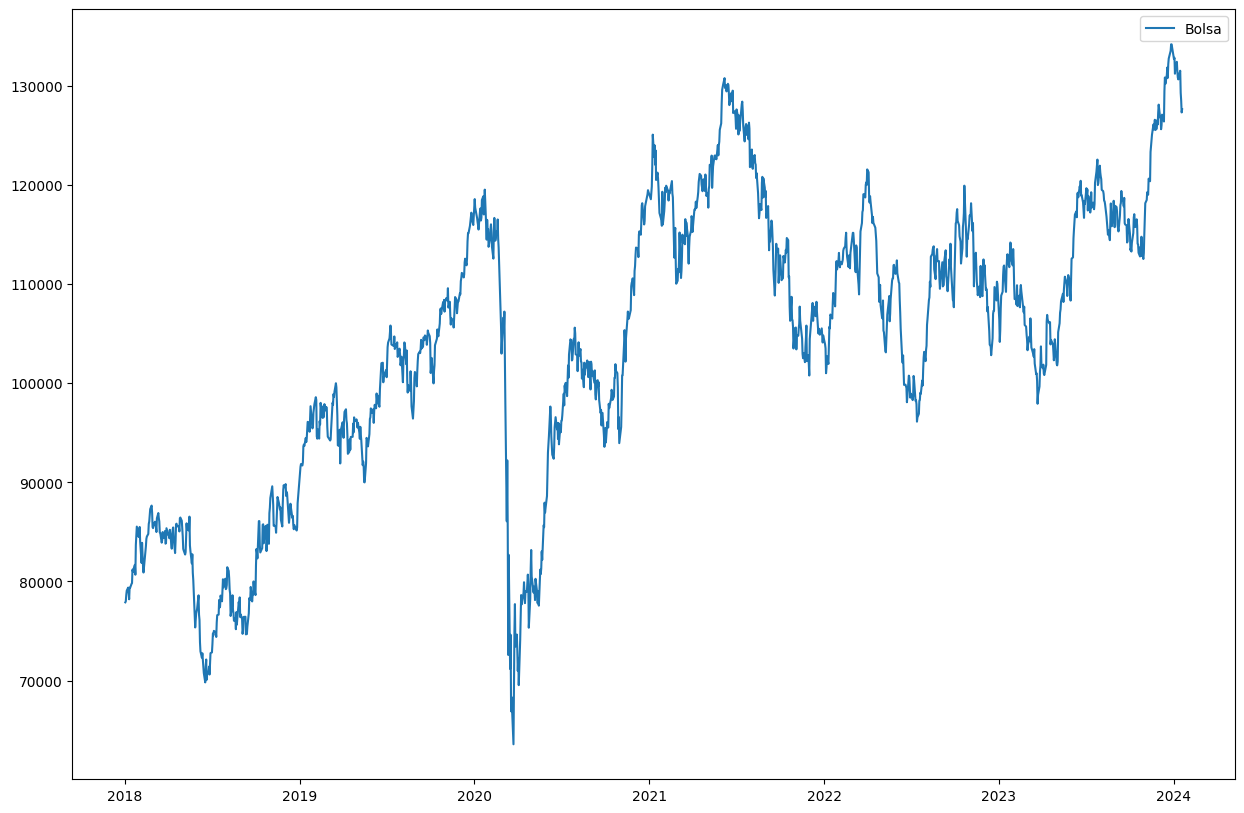

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(df_inicial['Date'], df_inicial['Adj Close'], label='Bolsa')

plt.legend(loc='best')
plt.show()

Guerra Comercial EUA-China (2018-2019): As tensões comerciais entre os Estados Unidos e a China foram um dos principais impulsionadores da volatilidade nos mercados. Tarifas comerciais foram impostas por ambos os lados, criando incerteza sobre o comércio internacional e afetando as perspectivas econômicas.

Desaceleração Econômica Global (2019-2020): Antes da pandemia de COVID-19, havia sinais de desaceleração econômica global. Vários países enfrentaram desafios econômicos, como o Brexit, a desaceleração na Europa e a diminuição do crescimento na China.

Pandemia de COVID-19 (2020): A propagação global do coronavírus em 2020 teve um impacto dramático nos mercados financeiros. Houve uma rápida venda de ativos, resultando em grandes quedas nos índices de ações em todo o mundo. Os governos responderam com medidas de estímulo e políticas monetárias expansionistas para tentar mitigar os impactos econômicos.

Recuperação Pós-COVID-19 (2020-2021): Após as quedas abruptas em março de 2020, muitos mercados experimentaram uma recuperação robusta à medida que os investidores respondiam positivamente às medidas de estímulo e à expectativa de uma recuperação econômica.

Política Monetária (2018-2021): Os bancos centrais em muitos países adotaram políticas monetárias expansionistas para estimular o crescimento econômico e fornecer suporte aos mercados financeiros. Isso incluiu cortes nas taxas de juros e programas de compra de ativos.

Inovação e Tecnologia (2018-2021): Empresas de tecnologia desempenharam um papel crucial nos mercados de ações, com um aumento notável no valor de muitas gigantes tecnológicas. O setor de tecnologia teve um desempenho particularmente forte durante esse período.

Incertezas Políticas (2018-2021): Incertezas políticas, como eleições presidenciais, decisões de políticas governamentais e mudanças nas lideranças, influenciaram os mercados em diferentes regiões do mundo.

# Análise de série temporal (Decomposição) 📈


Upload do dataframe 2023 a 2024 - Entre Março e Maio o gráfico caiu

In [184]:
import yfinance as yf

# Especifique o símbolo da Bolsa ('^BVSP') e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2023-01-01'
end_date = '2024-01-01'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [185]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-02,109734.0,109734.0,105981.0,106376.0,106376.0,8130500
1,2023-01-03,106377.0,106684.0,103852.0,104166.0,104166.0,14466700
2,2023-01-04,104167.0,105627.0,103915.0,105334.0,105334.0,14451200
3,2023-01-05,105336.0,107743.0,105333.0,107518.0,107518.0,15512000
4,2023-01-06,107642.0,109433.0,107642.0,108836.0,108836.0,12626600


In [186]:
df.shape #analisando linhas e colunas

(248, 7)

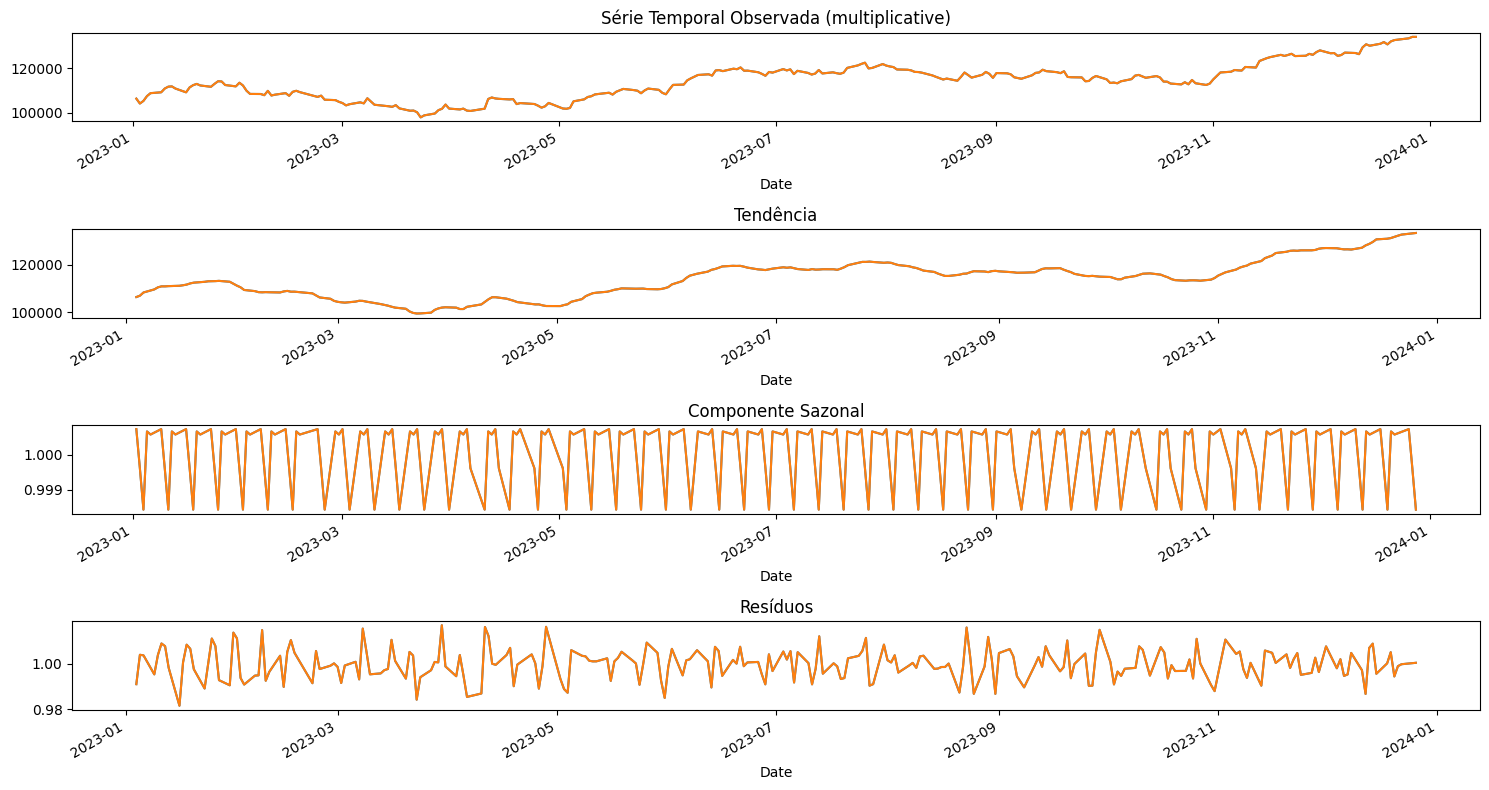

In [187]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close']) # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

################################## Notas da análise de decomposição da série ########################################

# model='additive': Este parâmetro especifica o tipo de modelo utilizado na decomposição.

# Os dois tipos principais são:

# "additive" (modelo apropriado quando a magnitude da sazonalidade não varia com a tendência)
# "multiplicative" (modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência).

# period: Este é o período da sazonalidade. Ele especifica o número de observações em um ciclo sazonal.

######################################################################################################################
seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos

# Plotando as séries nos subplots
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)

# Adicionando títulos aos subplots
ax1.set_title('Série Temporal Observada (multiplicative)')
ax2.set_title('Tendência')
ax3.set_title('Componente Sazonal')
ax4.set_title('Resíduos')



plt.tight_layout()

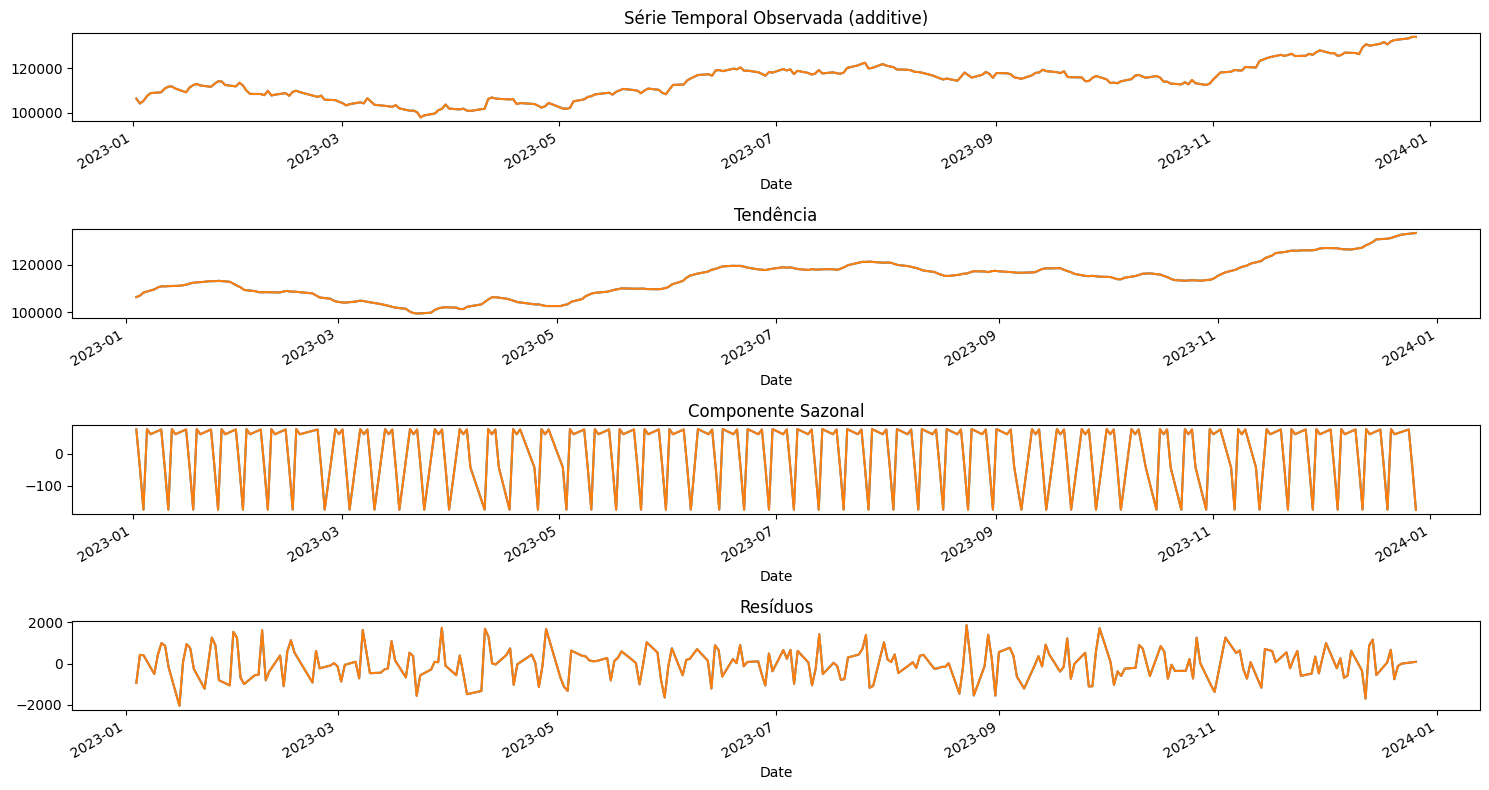

In [188]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Close']) # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

################################## Notas da análise de decomposição da série ########################################

# model='additive': Este parâmetro especifica o tipo de modelo utilizado na decomposição.

# Os dois tipos principais são:

# "additive" (modelo apropriado quando a magnitude da sazonalidade não varia com a tendência)
# "multiplicative" (modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência).

# period: Este é o período da sazonalidade. Ele especifica o número de observações em um ciclo sazonal.

######################################################################################################################

seasonplot = seasonal_decompose(df_limpo, model='additive', period=5) #decopondo a série temporal
#seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos

# Plotando as séries nos subplots
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)

# Adicionando títulos aos subplots
ax1.set_title('Série Temporal Observada (additive)')
ax2.set_title('Tendência')
ax3.set_title('Componente Sazonal')
ax4.set_title('Resíduos')

plt.tight_layout()